# Read data and perform fit to find PE/MeV

#### Created by Jorge Torres, 4/20/2022
#### Updated by Andrew Zheng, 4/30/2022
This notebook reads the data produced by the CAEN 5202 module when taking background runs for the prototype panels. It then fits the PE peaks to find the PE/MeV. All important files and figures are saved in a directory labelled /figures-YYYYMMDDHHMMSS, where the datetime associated with the folder is when the script was run.

### Import needed libraries

In [2]:
import ROOT

import sys
import math

import numpy as np

from ROOT import TH1D,TF1, gRandom, gPad, gStyle, TCanvas
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors as colors
from scipy.optimize import curve_fit
import scipy.signal
from lmfit.models import GaussianModel, ConstantModel
from datetime import datetime
from glob import glob

Welcome to JupyROOT 6.24/02


In [3]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

### Import parser that Tom wrote. This is containted in the file named $\texttt{dt5202.py}$ in this folder

In [6]:
from dt5202 import dt5202_crunch

# from dt5202oldDAQ import dt5202_crunch as dt5202_crunch_oldDAQ
ped = 50 #pedestal correction

In [8]:
FolderDictionary = {
   # "/data/brick2BckgrndL1_20230629.0/":1,      #0
   # "/data/brick2BckgrndL2_20230629.0/":1,   
    "/home/dt592/data/CsSwirlyDin1_20230710/":1,
#     "/data/brick2Co60L2_20230629.0/":1,         #2
#     "/data/brick2Co60L3tvk_20230630.0/":1,
#     "/data/brick2Co60L3Al_20230703.0/":1,
#     "/data/brick2Co60L1_20230629.0/":1,
    #"/data/brick2BckgrndL1Out1_20230705.0/":1,  #3
    #"/data/brick2BckgrndL1Out1cov_20230705.0/":1, #4
    #"/data/brick2BckgrndL3tvk_20230630/":1,     
    #"/data/brick2Co60L3tvk_20230630.0/":1,          #5
    #"/data/brick2BckgrndL1Out1covF_20230705.0/":1,
    #"/data/brick2BckgrndL1Out2_20230705.0/":1,
    #"/data/brick2BckgrndL1Mummy20230705.0/":1,
    #"/data/brick2BckgrndL1Out3Dark_20230705.0/":1,
    #"/data/brick2BckgrndL1Out3_20230705.0/":1,
    #"/data/brick2BckgrndL1Out3.5_20230705.0/":1,
#     "/data/BackgroundTest.1/":2,
#     "/data/BackgroundTest.2/":2,
#     "/data/BackgroundTest.3/":1,
#     "/data/BackgroundTest.4/":2,
#     "/data/BackgroundTest.5/":2,
#     "/data/BackgroundTest.6/":2,
}


#Store the keys:values
keys = list(FolderDictionary.keys())
values = list(FolderDictionary.values())

file_list = []

for i in range(len(FolderDictionary)):
    globals()["data_list" + str(i)] = []
    file_list.append(globals()["data_list" + str(i)])
    
for i in range (len(FolderDictionary)):
    file_list[i] = [f for f in os.listdir(keys[i]) if '.dat' in f]
    for file in file_list[i]:
        globals()["data_list" + str(i)].append(dt5202_crunch(str(keys[i])+str(file), num_ch=values[i]))
        

for i in range(len(FolderDictionary)):
    globals()["data" + str(i)] = None
    
    if (len(globals()["data_list" + str(i)][0]) > 0):
        globals()["data" + str(i)] = globals()["data_list" + str(i)][0]
        data_list = globals()["data_list" + str(i)]
        data = globals()["data" + str(i)]
        
    for j in range(1, len(data_list)):
        globals()["data" + str(i)] = np.append(data, [data_list[j]])
        



[(259, [3, 0, 3], 1, 0, 288, 0.5, 1689019979043)]
((33, 0, 1.68901998e+09, 0, 256), (8, 3, 267, 2716))


In [9]:
# Create folder based on datetime and path for where we will save the images.
# Get current date and time
# This way, if this code block needs to be run again with updated data, we will save files into a new folder
#now = datetime.now()
#dt_string = now.strftime("%Y%m%d%H%M%S")
#directory_name = '/figures-' + dt_string
#figure_folder = os.getcwd() + directory_name
#print(figure_folder)

#os.mkdir(figure_folder)                                
#print("Figures Directory created at path '% s'" % figure_folder)

In [10]:
#plotting High Gain Data to View SPE peaks
plt.figure(figsize=(8,5))
#plt.hist(data3['data']['high_gain'][:]-ped, bins=440,
 #        histtype='step', label=[sourceFolder3]);
#plt.hist(data2['data']['high_gain'][:]-ped, bins=440,
 #        histtype='step', label=[sourceFolder2]);
#plt.hist(data1['data']['high_gain'][:]-ped, bins=440,
 #        histtype='step', label=[sourceFolder1]);
plt.hist(data3['data']['high_gain'][:]-ped, bins=440,
         histtype='step', label=[sourceFolder4]);
plt.yscale('log')
#plt.xlim(500,3000)
plt.xlabel('ADC Counts')
plt.ylabel('Number of Events (Counts)')
plt.title('HG Histogram: ADC Counts')
#plt.savefig(figure_folder + '/' + 'ADCHist_HighGainBigPanel.png')
plt.legend()

NameError: name 'data3' is not defined

<Figure size 576x360 with 0 Axes>

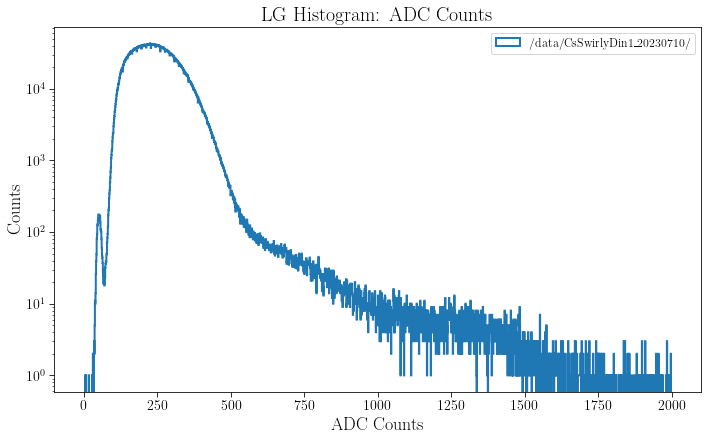

In [8]:
#for plotting
plt.figure(figsize=(10,6))
plt.hist(data0['data']['low_gain'][:],
        histtype='step', lw = 2., bins = 2000, label=keys[0],range = (0,2000));
#plt.hist(data1['data']['low_gain'][:],
 #       histtype='step', lw = 2., bins = 400, label=keys[1], range = (0,400));
#plt.hist(data2['data']['low_gain'][:],
 #       histtype='step', lw = 2., bins = 400, label=keys[2], range = (0,400));
#plt.hist(data3['data']['low_gain'][:],
#     histtype='step', lw = 2., bins = 400, label=keys[3], range = (0,400));
#plt.hist(data4['data']['low_gain'][:,1]-ped,
   #     histtype='step', lw = 2., bins = 1000, label='Brick Outside 3 layers',range = (0,3000));
#plt.hist(data5['data']['low_gain'][:,1]-ped,
 #        histtype='step', lw = 2., bins = 1000, label='Brick Inside', range = (0,3000));
#plt.hist(data7['data']['low_gain'][:,1]-ped,
 #        histtype='step', lw = 2., bins = 1000, label='Brick Outside 2 layers', range = (0,3000));

#plt.hist(data8['data']['low_gain'][:,1],
 #        histtype='step', lw = 2., bins = 400, label=keys[8], range = (0,400));
#plt.hist(data9['data']['low_gain'][:],
 #        histtype='step', lw = 2., bins = 1000, label=keys[9], range = (0,3000));
#plt.hist(data10['data']['low_gain'][:],
 #        histtype='step', lw = 2., bins = 400, label=keys[10],range = (0,1000));
#plt.hist(data11['data']['low_gain'][:],
 #       histtype='step', lw = 2., bins = 400, label=keys[11],range = (0,400));


plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.tight_layout()
plt.title("LG Histogram: ADC Counts")
#plt.savefig(figure_folder + '/' + 'lowgainbackground.png')
plt.legend()

In [7]:
#for plotting
plt.figure(figsize=(10,6))
#plt.hist(data4['data']['low_gain'][:],
 #        histtype='step', lw = 2., bins = 400, label=[sourceFolder4], range = (0,750));
#plt.hist(data5['data']['low_gain'][:],
 #        histtype='step', lw = 2., bins = 400, label=[sourceFolder5], range = (0,750));
plt.hist(data1['data']['low_gain'][:],
         histtype='step', lw = 2., bins = 300, label=[sourceFolder1]);
#plt.hist(data3['data']['low_gain'][:],
 #        histtype='step', lw = 2., bins = 450, label=[sourceFolder3], range = (0,750));
plt.hist(data2['data']['low_gain'][:],
        histtype='step', lw = 2., bins = 335, label=[sourceFolder2], color = 'green');
plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.tight_layout()
plt.title("LG Histogram: ADC Counts")
#plt.savefig(figure_folder + '/' + 'lowgainbackground.png')
plt.legend()

NameError: name 'sourceFolder1' is not defined

<Figure size 720x432 with 0 Axes>

## Manual analysis (peak centers + integration)

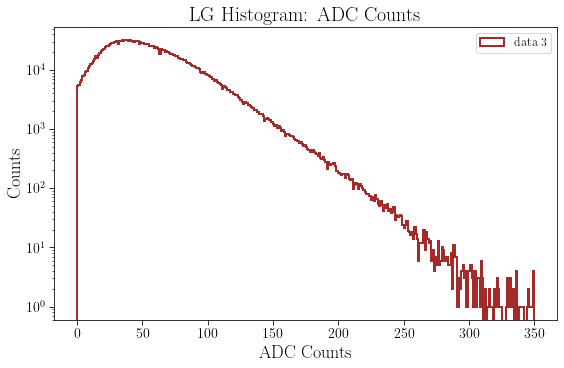

In [25]:
#for integration
plt.figure(figsize=(8,5))
n, bins, _ = plt.hist(data4['data']['low_gain'][:]-ped,
         histtype='step', lw = 2., bins = 350, label=["data 3"], color = 'brown', range = (0,350));
#m, bins2, _ = plt.hist(data4['data']['low_gain'][:]-ped,
 #       histtype='step', lw = 2., bins = 350, label=["data 4"], color = 'green', range = (50,400));
plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.tight_layout()
plt.title("LG Histogram: ADC Counts")
#plt.savefig(figure_folder + '/' + 'lowgainbackground.png')
plt.legend()

In [26]:
bin_width = bins[1]-bins[0]
bin = 0
lower_lim = bin/bin_width # locate lower limit
uper_lim = len(n)
print(lower_lim)
print(uper_lim)
print(bins[bin])
print(bins[len(n)])
print(n[349])

0.0
350
0.0
350.0
4.0


In [26]:
bin_width = bins2[2]-bins2[1]
lower_lim = 50/bin_width # locate lower limit
uper_lim = len(m)
print(lower_lim)
print(uper_lim)
print(bins[53])
print(n[349])
print(bin_width)

NameError: name 'bins2' is not defined

In [27]:
low = 0
high = 50
nsub1 = n[low:high]
least = low + np.argmin(nsub1)
nsub2 = n[least:300]
greatest1 = least + np.argmax(nsub2)
print('minimum bin:', least)
print('minimum adc:', bins[least+1])
print('counts at minimum bin:', n[least])
print('maximum bin:', greatest1)
print('maximum adc:', bins[greatest1+1])
print('counts at maximum bin', n[greatest1])

minimum bin: 0
minimum adc: 1.0
counts at minimum bin: 5287.0
maximum bin: 38
maximum adc: 39.0
counts at maximum bin 31973.0


In [41]:
low = 52
high = 160
msub1 = m[low-ped:high-ped]
least = low-ped + np.argmin(msub1)
msub2 = m[least:300]
greatest2 = least + np.argmax(msub2)
print('minimum bin:', least)
print('minimum adc:', bins2[least+1])
print('counts at minimum bin:', m[least])
print('maximum bin:', greatest2)
print('maximum adc:', bins2[greatest2+1])
print('counts at maximum bin', m[greatest2])

NameError: name 'm' is not defined

In [53]:
# integral = np.trapz(data1['data']['low_gain'][300:8001])
low = 300
high = 8000
integral = bin_width * sum(n[low-ped:high-ped])
print(integral)
print(least)

2172.0
273


In [30]:
len(data2['data']['low_gain'])

2753804

In [54]:
A = 6*25 #area in cm^2
Phi = 1 #flux in events/(cm^2*min) from brookhaven data
t = 25 #min

Events = Phi*A*t #expected events
print(Events, 'events')

Flux = integral/Events #calculated flux from data
print(Flux, 'events/cm^2/min')

3750 events
0.5792 events/cm^2/min


## Fit muon peak in low gain 

In [10]:
#%cd /home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
from langaus import LanGausFit
#%cd -
from root_numpy import array2hist, hist2array, fill_hist

In [26]:
c1 = ROOT.TCanvas('c1','')
hpx = ROOT.TH1D('Landau-Gauss Fit','pls',500,0,150000)
integ_ADC = np.array(data5['data']['low_gain'][:,1]-ped)
fill_hist(hpx, integ_ADC)

/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(


MPV 900.0928260775354
 FCN=66.0611 FROM MIGRAD    STATUS=FAILED       1151 CALLS        1152 TOTAL
                     EDM=0.000436305    STRATEGY= 1      ERR MATRIX APPROXIMATE
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   1.23619e+02   1.84488e+01   2.64604e-02   4.31843e-06
   2  LandauMPV    9.00093e+02   1.28079e+01   4.31221e-02  -7.41700e-04
   3  Normalisation   1.69561e+02   5.83425e+01   1.80260e-02   2.23277e-05
   4  GaussianSigma   1.28698e+02   4.25634e+01   1.51891e-02   3.26538e-04
                               ERR DEF= 0.5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <Fit>: Abnormal termination of minimization.


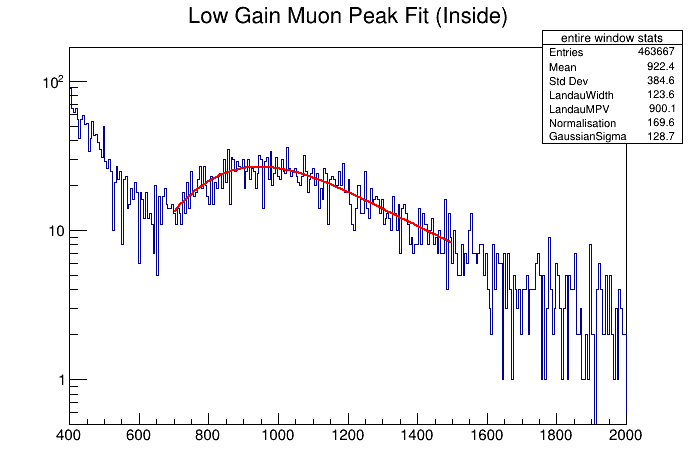

In [27]:
c1 = ROOT.TCanvas('c1','')
hpx = ROOT.TH1D('entire window stats','Low Gain Muon Peak Fit (Inside)',300,400,2000)
fill_hist(hpx,integ_ADC)
hpx.Draw()
ROOT.gPad.SetLogy()
ROOT.gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx,fitrange=(700,1500))
hpx.Draw()
func.Draw("same")
c1.Draw()
MPV = func.GetParameter(1) # this corresponds to the most probable value of the distribution
print("MPV", MPV)


## Fit multi-gaussian to peaks

Guess the fitting values. I'd suggest leave as it is, since it took me a long time to fine tune and it seems to be very finicky.
<br>This calculates the spe peaks which can be used to convert ADC to PE. (spe in Tom's code).

In [31]:
def make_model(num):
    pref = "f{0}_".format(num)
    model = GaussianModel(prefix = pref)
    model.set_param_hint(pref+'amplitude', value=amplitude[num], min=1, max=200*amplitude[num])
    model.set_param_hint(pref+'center', value=center[num], min=center[num]-10, max=center[num]+10)
    model.set_param_hint(pref+'sigma', value=width[num], min=1, max=50)
    return model

Text(0.5, 0, 'Integrated ADC')

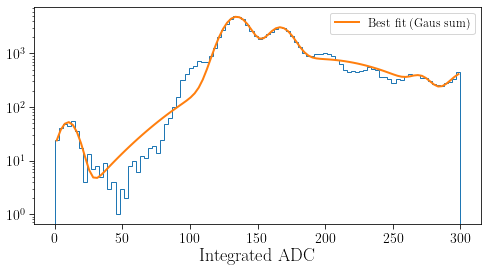

In [32]:
plt.figure(figsize=(8,4))

bin_heights, bin_borders, _ = plt.hist(np.array(data3['data']['high_gain'][:]-ped), bins=100,range=(0,300), density=False, histtype='step');
#bin_heights, bin_borders, _ = plt.hist(np.array(data['data']['high_gain']-ped), bins=100,range=(500,900), density=False, histtype='step');
#(200,580)
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=2)
number_of_peaks = len(peaks_in_interval)
amplitude = bin_heights[peaks_in_interval]
width = np.zeros(number_of_peaks) + 10
center = bin_centers[peaks_in_interval]

mod = None
for i in range(number_of_peaks):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value=np.average(bin_heights))
mod = mod #+ offset

out=mod.fit(bin_heights, x=bin_centers)

plt.plot(bin_centers, out.best_fit, label='Best fit (Gaus sum)', lw = 2)
#plt.plot(bin_centers, out.init_fit, 'r--', label='fit with initial values')
plt.legend()
plt.yscale('log')
plt.xlabel("Integrated ADC")

# sigmas = np.array(sigmas)
# sigm_avg.append(sigmas.mean())
# sigm_std.append(sigmas.std()/np.sqrt(len(sigmas)))
# redchi.append(out.redchi)
# plt.yscale('log')
# plt.ylim(1,1E5)

In [33]:
out.params.pretty_print(columns=['value', 'min', 'max', 'stderr'])

Name             Value      Min      Max   Stderr
f0_amplitude     866.7        1     8800     None
f0_center        9.995      0.5     20.5     None
f0_fwhm          15.89     -inf      inf     None
f0_height        51.26     -inf      inf     None
f0_sigma         6.746        1       50     None
f1_amplitude  1.034e+05        1 9.768e+05     None
f1_center        134.2    126.5    146.5     None
f1_fwhm          21.83     -inf      inf     None
f1_height         4453     -inf      inf     None
f1_sigma         9.269        1       50     None
f2_amplitude  5.208e+04        1 5.966e+05     None
f2_center        166.5    159.5    179.5     None
f2_fwhm           20.5     -inf      inf     None
f2_height         2387     -inf      inf     None
f2_sigma         8.704        1       50     None
f3_amplitude  9.885e+04        1 1.984e+05     None
f3_center        192.5    192.5    212.5     None
f3_fwhm          117.7     -inf      inf     None
f3_height        788.7     -inf      inf    

#### Calculate the peak center differences from the fit parameters and average them out

In [34]:
peak_fitCenter = []
print(len(peaks_in_interval))

for i in range(len(peaks_in_interval)):
    try:
        if out.values["f%i_amplitude"%(i)]>1e5:
            print(out.values["f%i_center"%(i+1)]-out.values["f%i_center"%i])
            peak_fitCenter.append(out.values["f%i_center"%(i+1)]-out.values["f%i_center"%i])
        else:
            print(out.values["f%i_amplitude"%(i)])
    except:
        break
peak_fitCenter = np.array(peak_fitCenter)
print(peak_fitCenter)

7
866.7290423937427
32.24946762733097
52083.66711254141
98853.24015785956
1.0000000000055733
2698.0945570187578
11198.701713915825
[32.24946763]


In [35]:
import statistics 
print (np.std(peak_fitCenter),peak_fitCenter)
singlePEaverage = []
for i in range(0,3):
    print (out.values["f%i_sigma"%(i)])
    singlePEaverage.append(out.values["f%i_sigma"%(i)])
    
print( "Average is %f"%(sum(singlePEaverage)/len(singlePEaverage)))
print(str(round( statistics.mean(singlePEaverage),2)))

#print(out.values)

0.0 [32.24946763]
6.74613739500337
9.268594935138307
8.704211045187385
Average is 8.239648
8.24


[ 95 621 282 189 434 435 264 378 128 133]
[ 95 621 282 189 434 435 264 378 128 133]
177
[ 95 621 282 189 434 435 264 378 128 133]
[ 95 621 282 189 434 435 264 378 128 133]


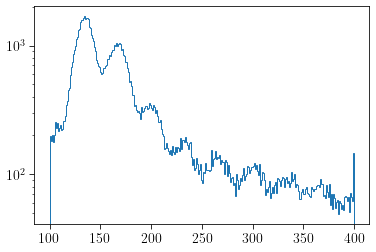

In [36]:
#trying to make a better fitter
fitter = np.array(data3['data']['high_gain'][:]-50)
PEfit = fitter[fitter<5000]
#plt.hist(fitter,bins=100,histtype='step', label=["Board 17771"],range=(100,400))
#plt.hist(data['data']['high_gain'], bins=100, histtype='step', label=["Board 17771"],range=(100,400));
plt.hist(PEfit,bins=300, histtype='step', label=["Board 17771"],range=(100,400))
print (fitter[0:10])
print (PEfit[0:10])
print (fitter[-1])
np.sort(fitter)
newPE =np.sort(PEfit)
print (PEfit[0:10])
print (fitter[0:10])
#plt.xlim(130,330)
plt.yscale('log')

#bin_heights, bin_borders, _ = plt.hist(np.array(data['data']['high_gain']-ped), bins=100,range=(100,400), density=False, histtype='step');

#bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2


#peaks_in_interval = scipy.signal.find_peaks_cwt(bin_heights, widths=1)
#print (peaks_in_interval)


(array([53., 74., 30., 21., 10.,  2.,  2.,  2.,  3.,  3.]),
 array([ 49. ,  78.8, 108.6, 138.4, 168.2, 198. , 227.8, 257.6, 287.4,
        317.2, 347. ]),
 <BarContainer object of 10 artists>)

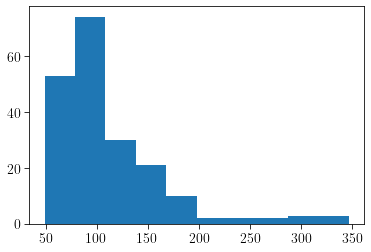

In [37]:
#okay let me try to see if i can fit two gaussians in the distribution
hist,bin_edges = np.histogram(PEfit,bins=300,range=(100,400))
bin_centers = .5*(bin_edges[:-1] + bin_edges[1:]) #get bin_centers
B=hist[100:400]
plt.hist(B)


In [38]:
ADC_to_PE = peak_fitCenter.mean().round() #the mean, rounded since ADC counts are integers
spe = ADC_to_PE

#I want to test what happens when 
#This number corresponds to the ADC/P.E.
print(spe)

32.0


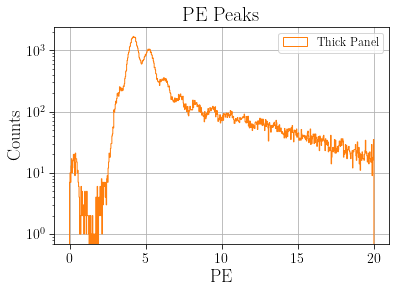

In [39]:
plt.hist((data3['data']['high_gain'][:]-ped)/spe, bins=640, range=(0,20),
         histtype='step',color='C1', label = 'Thick Panel');
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid()
plt.ylim(0,)
plt.legend()
plt.title('PE Peaks')
plt.savefig(figure_folder + '/' + 'PEPeaks.png')

Text(0.5, 1.0, 'ADC Space')

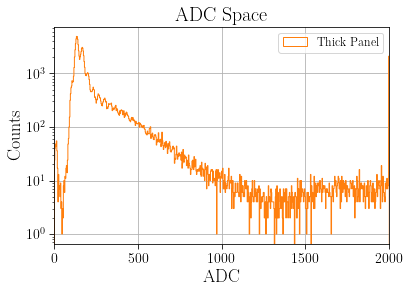

In [40]:
plt.hist((data3['data']['high_gain'][:]-ped), bins=1000, range=(0,3000),
         histtype='step',color='C1', label = 'Thick Panel');
plt.xlabel('~ADC')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid()
plt.xlim(-0,2000)
plt.ylim(0,)
plt.legend()
plt.title('ADC Space')

(1, 82.67582605078223)

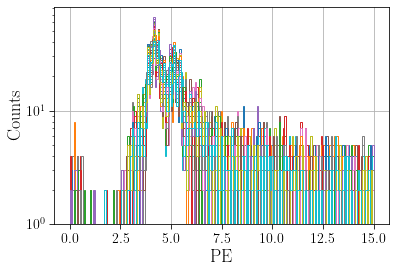

In [41]:
d = (data3['data']['high_gain'][:]-ped)/spe

n_ev = len(d)
n_steps = 100
n = n_ev // n_steps

for i in range(n_steps):
    plt.hist(d[i*n:(i+1)*n], bins=211, range=(0,15),
             histtype='step');
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid()
plt.ylim(1,)

## Calculate the ratio between high gain counts and low gain counts

This block uses Python's linear fit function to estimate the ratio of the counts between the high and low gain channels. Due to the count limit of the high gain channel, we will only use low gain data up to when the high gain threshhold is met.

171
Best Fit: y = 11.62x + 31.11
Ratio between high gain counts and low gain counts: 11.62


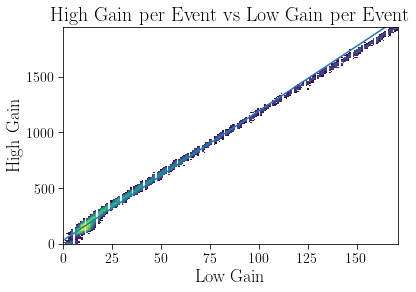

In [42]:
# Find maximum of high gain counts, then see when the low gain counts reaches that threshhold.
max_high_gain = max(data3['data']['high_gain'][:]-ped) - ped

# Initialize the low gain limit we want to use in the linear fit to a very high value.
# The low gain limit will not exceed the max_high_gain value, so this initialization should be sufficient for minimization.
low_gain_limit = max_high_gain

# Find the minimum point in low gain counts that reaches the threshold.
for data_point_index in range(len(data3['data']['low_gain'][:])):
    if max_high_gain == data3['data']['high_gain'][:][data_point_index] - ped:
        if (data3['data']['low_gain'][:][data_point_index] - ped) < low_gain_limit:
            low_gain_limit = (data3['data']['low_gain'][:][data_point_index] - ped)

print(low_gain_limit)

# Plot histogram within this range above, as we are only interested in coincident data
plt.hist2d(data3['data']['low_gain'][:]-ped, (data3['data']['high_gain'][:]-ped), bins=200, range=((0,low_gain_limit),(0,max_high_gain)), norm=LogNorm());
# print(max(data['data']['low_gain'][:,0])-ped)
# print(max(data['data']['high_gain'][:,0]-ped)/rat)
# plt.plot(np.linspace(start=0,stop=1000,num=1000)) 

# Initialize two new np arrays with high and low gain count data in the ranges defined above
low_gain = []
high_gain = []

# Low gain is always going to have data above the threshhold, so we will only add data from the dataset that has a low gain count under the limit set above.
# Create two new np arrays: low gain counts and high gain counts that only include data within the minimum of the maximums
for data_point_index in range(len(data3['data']['low_gain'][:])):
    if data3['data']['low_gain'][:][data_point_index] - ped <= low_gain_limit:
        low_gain.append(data3['data']['low_gain'][:][data_point_index] - ped)
        high_gain.append((data3['data']['high_gain'][:][data_point_index] - ped))

#Fit a line to the histogram
m, b = np.polyfit(low_gain, high_gain, 1)
print('Best Fit: y = ' + str(round(m, 2)) + 'x + ' + str(round(b,2)))
print('Ratio between high gain counts and low gain counts: ' + str(round(m, 2)))

# Plot line of best fit
plt.plot([0, low_gain_limit], [m*0+b, m*low_gain_limit+b])
# plt.plot(data['data']['low_gain'][:,0]-ped, m*(data['data']['low_gain'][:,0]-ped)+b)

# Set Plot Descriptors and Ranges
plt.xlim(0,low_gain_limit)
plt.ylim(0,max_high_gain)
plt.title('High Gain per Event vs Low Gain per Event')
plt.xlabel('Low Gain ')
plt.ylabel('High Gain ')

rat = m

# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'Hist_HighLow.png')

In [43]:
print("Ratio between high and low gain counts: " + str(rat))
print("Conversion from ADC to PE: " + str(spe))
#rat = 11.41

Ratio between high and low gain counts: 11.616500990819393
Conversion from ADC to PE: 32.0


## Some graphs, converting ADC to PE and normalizing high gain and low gain counts by estimated ratio

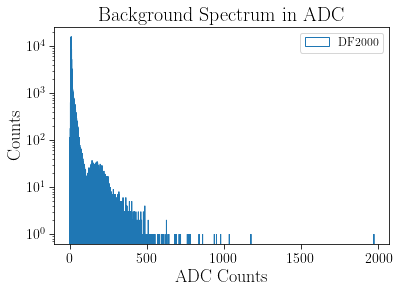

In [44]:
plt.hist(data3['data']['low_gain'][:]-ped, bins='auto',label=["DF2000"],histtype='step');
#plt.hist(data['data']['low_gain'], bins='auto',label=["Optical Cement"]);
# plt.xlim(0,4000)
# plt.ylim(0,1000)
plt.title('Background Spectrum in ADC')
plt.xlabel('ADC Counts')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
#plt.savefig(figure_folder + '/' + 'ADCBackgroundSpectrum.png')

(0.0, 200.0)

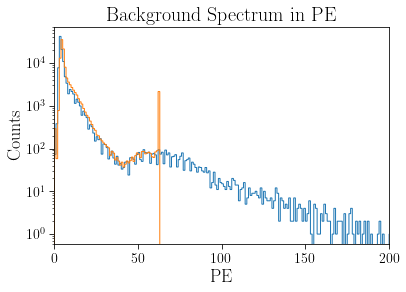

In [45]:
d = data3['data']['low_gain'][:]-ped
#d = data['data']['low_gain']-ped
plt.hist(d.astype('float64')*rat/spe, bins=700, range=(0,700),histtype='step');
d = data3['data']['high_gain'][:]-ped
#d = data['data']['high_gain']-ped
plt.hist(d.astype('float64')/spe, bins=700, range=(0,700),histtype='step');
plt.yscale('log')
plt.title('Background Spectrum in PE')
plt.xlabel("PE")
plt.ylabel("Counts")
plt.xlim(0,200)
# Can work on naming scheme
#plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum.png')

Text(0.5, 1.0, 'Low Gain Coincidence Histogram')

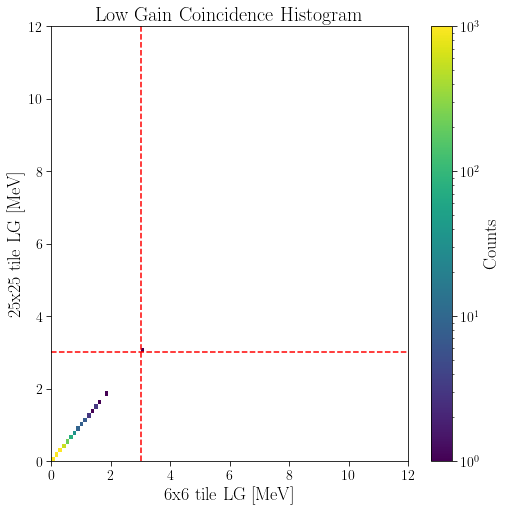

In [46]:
plt.figure(figsize=(8,8))
#rat = 11.14
rat = rat
spe=121.0
pe_per_MeV = 62.22
t_25 = (data3['data']['low_gain'][:]-ped)*rat/spe/pe_per_MeV
t_6 = (data3['data']['low_gain'][:]-ped)*rat/spe/pe_per_MeV
#plt.hist2d(t_6.astype('float64'),t_25.astype('float64'),bins=100, range=((0,max(data['data']['low_gain'][:,0])/2),(0,max(data['data']['low_gain'][:,1]))), norm=LogNorm(vmax=1000))
plt.hist2d(t_6.astype('float64'),t_25.astype('float64'),bins=100, range=((0,12),(0,12)), norm=LogNorm(vmax=1000))
plt.axhline(y=3, color='r', linestyle='--')
plt.axvline(x=3,color='r',linestyle='--')
# plt.xlim(0,2000)
plt.xlabel('6x6 tile LG [MeV]')
plt.ylabel('25x25 tile LG [MeV]')
plt.colorbar(label="Counts")
plt.title('Low Gain Coincidence Histogram')
# Can work on naming scheme
#plt.savefig(figure_folder + '/' + 'CoincidenceHistogram.png')

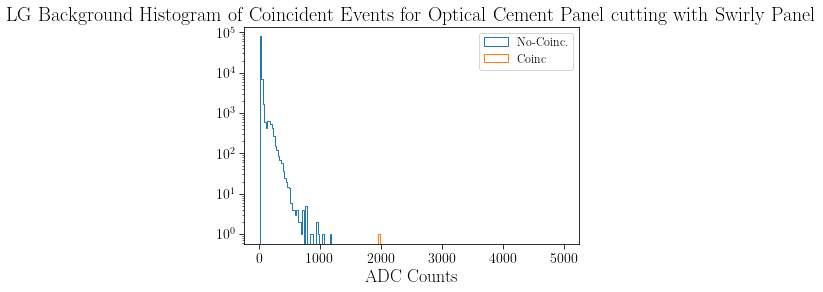

In [48]:
filter = data3['data']['low_gain'][:] > 2000
d = (data3['data']['low_gain'][:]-ped)
plt.hist(d, bins=200, range=(10,5000), histtype='step', label='No-Coinc.');
plt.hist(d[filter], bins=200, range=(10,5000), histtype='step', label='Coinc');
#plt.ylim(0,max(d[filter])*3/2)
plt.xlabel('ADC Counts');
plt.legend();
plt.yscale('log')
plt.title('LG Background Histogram of Coincident Events for Optical Cement Panel cutting with Swirly Panel')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'LowGainPEBackgroundSpectrum_Coincidence.png')

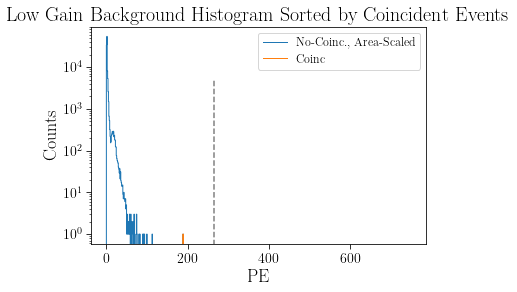

In [51]:
filter = data3['data']['low_gain'][:] > 2000

d = (data3['data']['low_gain'][:]-ped)*rat/spe

h1,bins = np.histogram(d, bins=740, range=(0,750))
h2,bins = np.histogram(d[filter], bins=740, range=(0,750))

#area_ratio = (6*6)/(25*25)
area_ratio=1
plt.stairs(h1*area_ratio, bins, label='No-Coinc., Area-Scaled')
plt.stairs(h2, bins, label='Coinc')
#plt.ylim(0,500)
plt.legend()
plt.xlabel('PE')
plt.ylabel('Counts')
plt.yscale('log')
plt.vlines(x=265, ymin=0,ymax=5000, linestyles='--', color='k', alpha=0.5)
plt.title('Low Gain Background Histogram Sorted by Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_Coincidence.png')

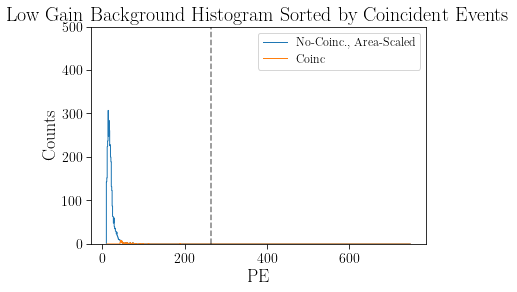

In [54]:
filter = data3['data']['low_gain'][:] > 500
d = (data3['data']['low_gain'][:]-ped)*rat/spe

h1,bins = np.histogram(d, bins=740, range=(10,750))
h2,bins = np.histogram(d[filter], bins=740, range=(10,750))

#area_ratio = (6*6)/(25*25)
area_ratio=1
plt.stairs(h1*area_ratio, bins, label='No-Coinc., Area-Scaled')
plt.stairs(h2, bins, label='Coinc')
plt.ylim(0,500)
plt.legend()
plt.xlabel('PE')
plt.ylabel('Counts')

plt.vlines(x=265, ymin=0,ymax=5000, linestyles='--', color='k', alpha=0.5)
plt.title('Low Gain Background Histogram Sorted by Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_Coincidence.png')

In [56]:
# Integration code for the prototype and the coincidence
d_lowgain = (data3['data']['low_gain'][:]-ped)*rat/spe

int_hist,bins = np.histogram(d_lowgain, bins=740, range=(10,750))
integral = sum(int_hist[191:])


print("Non-coincidence: Muon Count = " + str(round(integral/(1440*25*25), 2)) + " muons / min / cm^2")

d_coincidence = d[filter]
coincidence_histogram,bins = np.histogram(d[filter], bins=740, range=(10,750))
integral_coincidence = sum(coincidence_histogram[191:])
# print(integral_coincidence)

print("Coincidence: Muon Count = " + str(round(integral_coincidence/(1440*6.17*6.43), 2)) + " muons / min / cm^2")

Non-coincidence: Muon Count = 0.0 muons / min / cm^2
Coincidence: Muon Count = 0.0 muons / min / cm^2


## Now we can calculate the P.E./MeV by using the muon distribution from low gain data

#### A few technical details here: the Landau-Gaus fitting has to be done in ROOT, so I'll use ROOT here to do that. I'm first converting the numpy arrays into a TH1D object and then fitting.

In [57]:
from root_numpy import array2hist, hist2array, fill_hist
c1 = TCanvas( 'c1', 'Dynamic Filling Example', 200, 10, 700, 500 )
hpx = ROOT.TH1D( 'Gaussian-convoluted Landau', 'Background, no coincidences', 200, 0, 7500)
fill_hist(hpx, np.array(data3['data']['low_gain'][:]))
#fill_hist(hpx, np.array(data['data']['low_gain']))

/home/coure/Software/DataTakingVenv/lib/python3.8/site-packages/root_numpy/_hist.py:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return _librootnumpy.fill_h1(
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


/home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
/home/coure/aarondata
 FCN=1.97323e-05 FROM HESSE     STATUS=NOT POSDEF     25 CALLS        1459 TOTAL
                     EDM=6.35564e-08    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  LandauWidth   4.97245e-03   5.40393e-02   4.44259e-07  -2.73952e-03
   2  LandauMPV    2.00611e+03   9.32586e-01   9.56587e-05  -4.36343e-04
   3  Normalisation   6.78594e+05   8.05062e+06   4.00001e-01  -1.59769e-11
   4  GaussianSigma   5.04778e-06   6.02417e-05   4.92359e-10  -2.14798e+00
                               ERR DEF= 0.5


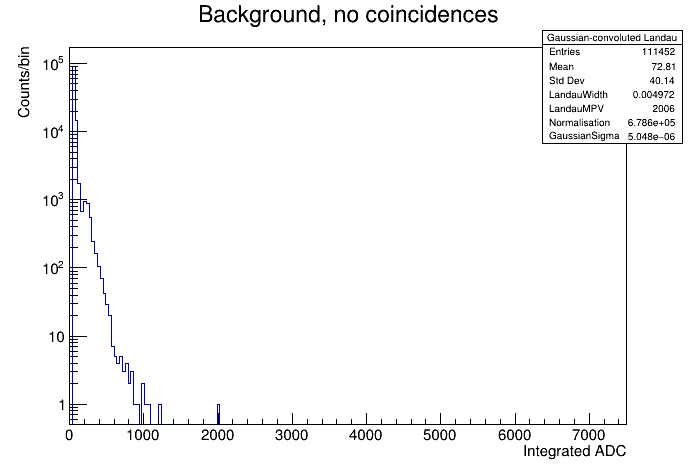

In [58]:
# Maybe it would be less confusing to include langaus in the same directory? I had trouble with this function because the file was not in the correct directory.
%cd /home/coure/Software/caenqdc_custom/scripts/PECollectionStudies
from langaus import LanGausFit
%cd - 

hpx.Draw()
# hpx.Fit("landau")
gPad.SetLogy();
gStyle.SetOptFit(2)
fit = LanGausFit()
func = fit.fit(hpx, fitrange=(2000,6000))
# The fitter return a ROOT TF1 (a 1D function).
# func.Print()
hpx.GetXaxis().SetTitle("Integrated ADC");
hpx.GetYaxis().SetTitle("Counts/bin");

hpx.Draw()
func.Draw("same")
c1.Draw()
# c1.SaveAs("Fitted_noCoincidences_swirlyTry2.pdf");


In [59]:
MPV = func.GetParameter(1) #This corresponds to the most probable value (MPV) of the distr.
print(MPV)

2006.1075068557852


### We can now use the muon dE/dx, the ADC/PE and the MPV to get the PE/MeV

In [60]:
muon_dE_dx = 2 #MeV/cm
panelWidth = 1 #cm
gainConversionFactor = 11#Check this with Samantha
#Then
pe_per_MeV = gainConversionFactor* MPV * 1/(ADC_to_PE) * 1/(muon_dE_dx*panelWidth)
print("PE/MeV = %0.2f"%pe_per_MeV) #PE/MeV

with open(figure_folder + '/' + 'PEMeV.txt', 'w') as f:
    f.write("PE/MeV = %0.2f"%pe_per_MeV)

PE/MeV = 344.80


## Extra Plots

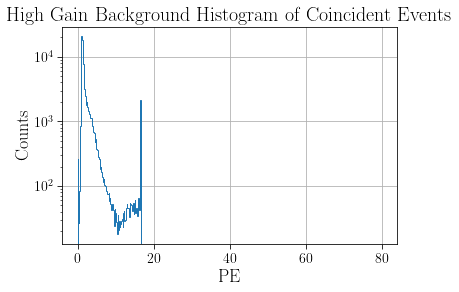

In [62]:
plt.hist((data3['data']['high_gain']-ped)/spe, bins=500, range=(0,80),
         histtype='step');
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.grid()
plt.yscale('log');
plt.title('High Gain Background Histogram of Coincident Events')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'HighGainPEBackgroundSpectrum_Coincidence.png')

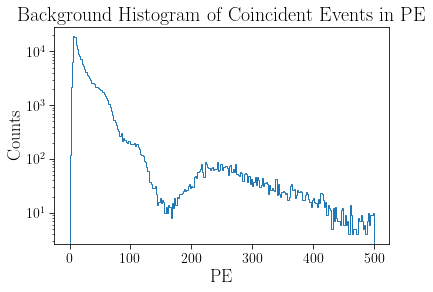

In [33]:
plt.hist((data['data']['low_gain'][:,0]-ped)*rat/spe, bins=250, range=(0,500),
         histtype='step');
plt.yscale('log')
plt.xlabel('~PE')
plt.ylabel('Counts')
plt.title('Background Histogram of Coincident Events in PE')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_CoincidenceOnly.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


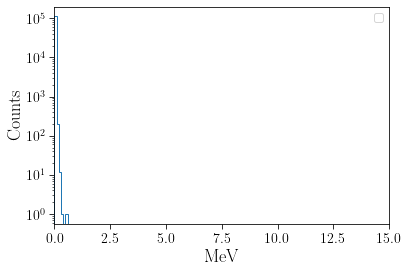

In [65]:
plt.hist((data3['data']['low_gain'][:]-ped)*rat/spe/pe_per_MeV, bins=150, range=(0,15),
         histtype='step');
plt.xlim(0,15)
#plt.ylim(0,500)
plt.legend()
plt.xlabel('MeV')
plt.ylabel('Counts')
plt.yscale('log')
#histogramData = (data['data']['low_gain'][:,0]-ped)*rat/spe/pe_per_MeV
#np.save("SwirlyPanel24HrRun"+'.npy', histogramData)

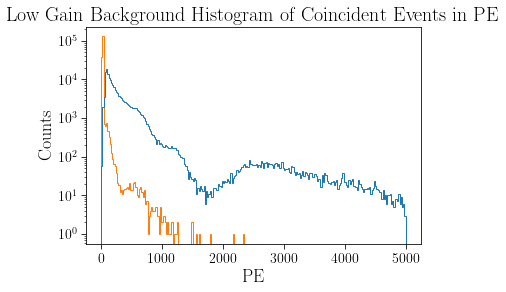

In [35]:
plt.hist((data['data']['low_gain']-ped), bins=250, range=(0,5000),
         histtype='step')
# plt.yscale('log');
# plt.ylim(0,2000);
plt.xlabel('~PE')
plt.yscale('log')
plt.ylabel('Counts')
# plt.vlines(35,0,20000)
plt.title('Low Gain Background Histogram of Coincident Events in PE')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'LowGainPEBackgroundSpectrum_Both.png')

In [36]:
mu = (data['data']['low_gain'][:,0]-ped)*rat/spe
len(mu[mu>180])/(data['header']['trigger_ts'][-1]-data['header']['trigger_ts'][0])

9.286652599684512

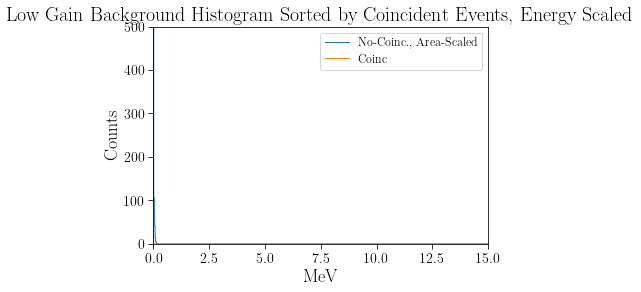

In [66]:
filter = data3['data']['low_gain'][:] > 2500
d = (data3['data']['low_gain'][:]-ped)*rat/spe/pe_per_MeV

h1,bins = np.histogram(d, bins=740, range=(0,15))
h2,bins = np.histogram(d[filter], bins=740, range=(0,15))

area_ratio = (6*6)/(25*25)
plt.stairs(h1*area_ratio, bins, label='No-Coinc., Area-Scaled')
plt.stairs(h2, bins, label='Coinc')
plt.xlim(0,15)
plt.ylim(0,500)
plt.legend()
plt.xlabel('MeV')
plt.ylabel('Counts')
plt.vlines(x=265, ymin=0,ymax=5000, linestyles='--', color='k', alpha=0.5)
plt.title('Low Gain Background Histogram Sorted by Coincident Events, Energy Scaled')
# Can work on naming scheme
plt.savefig(figure_folder + '/' + 'PEBackgroundSpectrum_Coincidence.png')